In [1]:
%matplotlib inline


Transfer learning for cortical columns



In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from batch_iterator import HistoBatchIterator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
plt.ion()   # interactive mode

In [4]:
def angle(angle1, angle2): 
    a=abs(180 - abs(abs(angle1 - angle2) - 180))
    return a

    
def mean_squared_angle_loss(output, target):
    #either rad or deg.
    loss = torch.mean((180 - abs(abs(output - target) - 180))**2)
    #loss = torch.mean((np.pi - abs(abs(output - target) - np.pi))**2)
    return loss

def mean_angle_loss(output, target):
    #either rad or deg.
    loss = torch.mean(abs(180 - abs(abs(output - target) - 180)))
    #loss = torch.mean(abs(np.pi - abs(abs(output - target) - np.pi)))
    return loss

Load Data
---------

In [5]:
data_params = {
    'batch_size': 32,
    #change from real or synthetic for histological vs synthetic data
    'real_or_synthetic': 'synthetic',
    #field of view
    'fov':200,
    #labelled_data type: angle, vector
    'label_type':'angle',

    
    #data augmentation
    'rotate':True,
    'noise':True,

    'val_fraction': 0.1,
    'test_fraction': 0.01,
    
    #input files for real data
    'json': 'data/cut_300.json',
    'histo': 'data/cut_300.tif',
    'shuffle':True,
    'seed':False,
    
    #synthetic data parameters
    'number_of_examples':1000,
    'jitter':20,
}

dataloaders = {x: HistoBatchIterator(data_params, mode=x)
               for x in ['train', 'val']}
dataset_sizes = {'train':data_params['number_of_examples'],
              'val':data_params['number_of_examples']*data_params['val_fraction']}

In [6]:
#load some demo data
inputs, classes = next(iter(dataloaders['val']))


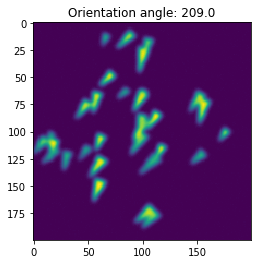

In [7]:
#visualising some examples
k=np.random.randint(32)
plt.title('Orientation angle: {}'.format(classes[k]))
plt.imshow(inputs[k,0])

Training the model
------------------


In [8]:
def train_model(model,criterion,  optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.
            k=0
            dataset_size=0
            for inputs, labels in dataloaders[phase]:
                #convert to rads
                #labels=np.deg2rad(labels)

                inputs = torch.from_numpy(inputs).float()
                labels = torch.from_numpy(labels).float()

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs,labels)
                    monitor_metric = mean_angle_loss(outputs,labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                dataset_size += inputs.size(0)
                running_loss += monitor_metric.item() * inputs.size(0)

                k+=1
                if k >= dataset_sizes[phase]/inputs.size(0):
                    break
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [9]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = torch.from_numpy(inputs).float()
            labels = torch.from_numpy(labels).float()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #outputs=np.rad2deg(np.array(outputs.cpu()))
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {},\ngt: {}'.format(outputs[j],labels[j]))
                plt.imshow(inputs.cpu().data[j,0])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return 
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#angle regression, so fix output to 1
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

#loss metric
criterion = mean_angle_loss
#  all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001 ) # , momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft,criterion,  optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 91.3076
val Loss: 87.2598

Epoch 1/24
----------
train Loss: 91.2254
val Loss: 93.3477

Epoch 2/24
----------
train Loss: 90.3234
val Loss: 91.7054

Epoch 3/24
----------
train Loss: 89.9196
val Loss: 89.2763

Epoch 4/24
----------
train Loss: 89.0200
val Loss: 99.0785

Epoch 5/24
----------
train Loss: 86.9851
val Loss: 133.4953

Epoch 6/24
----------
train Loss: 89.1781
val Loss: 91.2656

Epoch 7/24
----------
train Loss: 88.0109
val Loss: 88.1683

Epoch 8/24
----------


In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 1)

model_conv = model_conv.to(device)

# only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv,  optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()